In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from statsmodels.tsa.api import VAR
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [60]:
#  Загружаем данные
df_main = pd.read_excel('data_4.xlsx')
df_main.shape

(2355, 36)

In [171]:
#  Фиксируем рассматриваемые временные ряды:
a = 'r_2' # изменение цены за следующие после t_0 15 минут в центах
b = 'oi_diff_abs' # изменение открытого интереса (ОИ) за предыдущие 5 минут
c = 'Vol_diff_lots_abs'  # изменение объема в лотах за предыдущие 5 минут
d = 'oi_dum_2'  # дамми-переменная: 1, если изменение ОИ за 15 минут выше среднего по всей выборке

# МНК

In [174]:
df_new = df_main.copy()
df_new = df_new[[a, b, c]][0:2000]

for j in [b]:
    df_new[j + '_lag1'] = df_new[j].shift(1)
    df_new[j + '_lag2'] = df_new[j].shift(2)
    df_new[j + '_lag3'] = df_new[j].shift(3)
    df_new[j + '_lag4'] = df_new[j].shift(4)
    df_new[j + '_lag5'] = df_new[j].shift(5)
    df_new[j + '_lag6'] = df_new[j].shift(6)

df_new = df_new[[a,
                 b + '_lag1', b + '_lag2', b + '_lag3', b + '_lag4', b + '_lag5', b + '_lag6',
                 c]]
df_new = df_new.dropna().reset_index(drop=True)
df_new.head()

,r_2,oi_diff_abs_lag1,oi_diff_abs_lag2,oi_diff_abs_lag3,oi_diff_abs_lag4,oi_diff_abs_lag5,oi_diff_abs_lag6,Vol_diff_lots_abs
0,2.523530e-08,1038.0,264.0,338.0,466.0,2800.0,1098.0,2775
1,1.009733e-07,180.0,1038.0,264.0,338.0,466.0,2800.0,1184
2,2.522729e-08,1156.0,180.0,1038.0,264.0,338.0,466.0,1923
3,4.037649e-07,1614.0,1156.0,180.0,1038.0,264.0,338.0,21
4,1.008131e-07,930.0,1614.0,1156.0,180.0,1038.0,264.0,13


F:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:778: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


TimeSeriesSplit(max_train_size=None, n_splits=3)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232

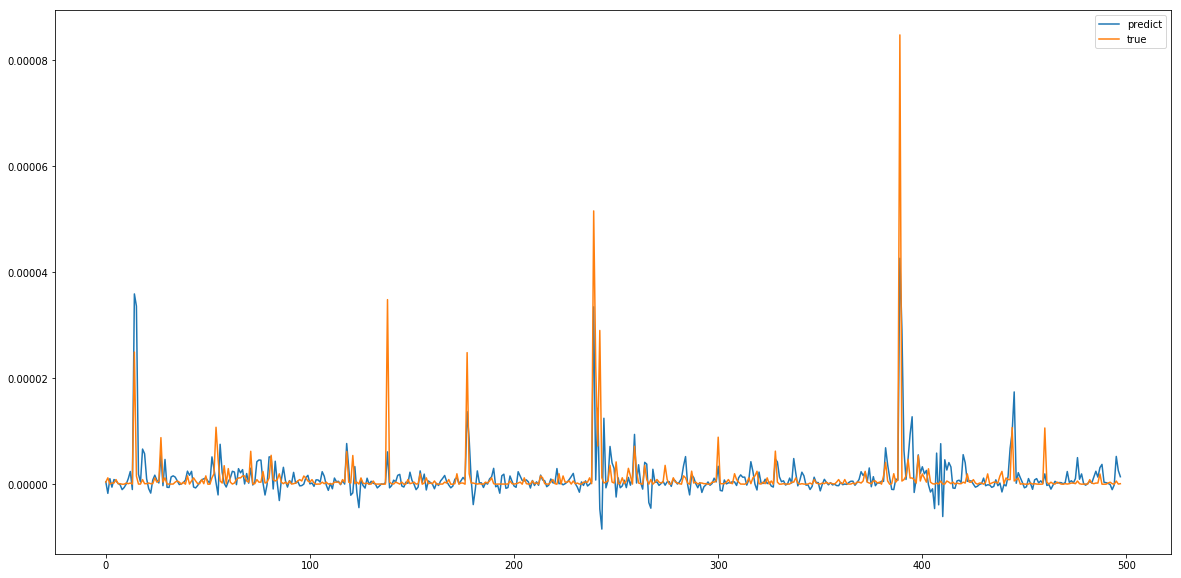

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

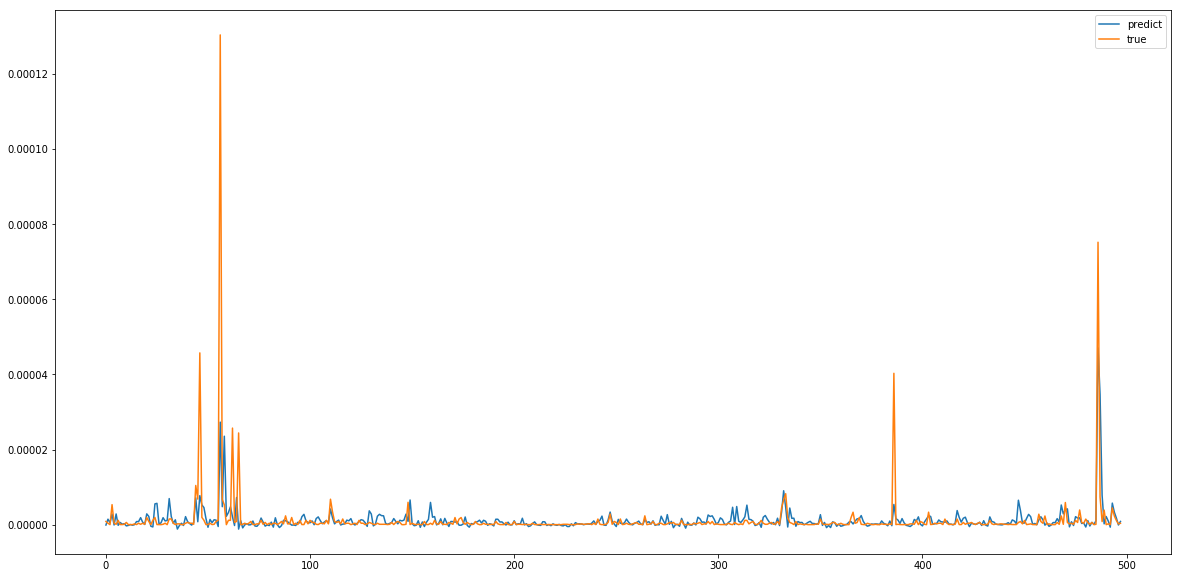

TRAIN: [   0    1    2 ... 1493 1494 1495] TEST: [1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509
 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523
 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537
 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551
 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565
 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579
 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593
 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607
 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621
 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635
 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649
 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663
 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677
 1678 1679 1680 1681 1682 16

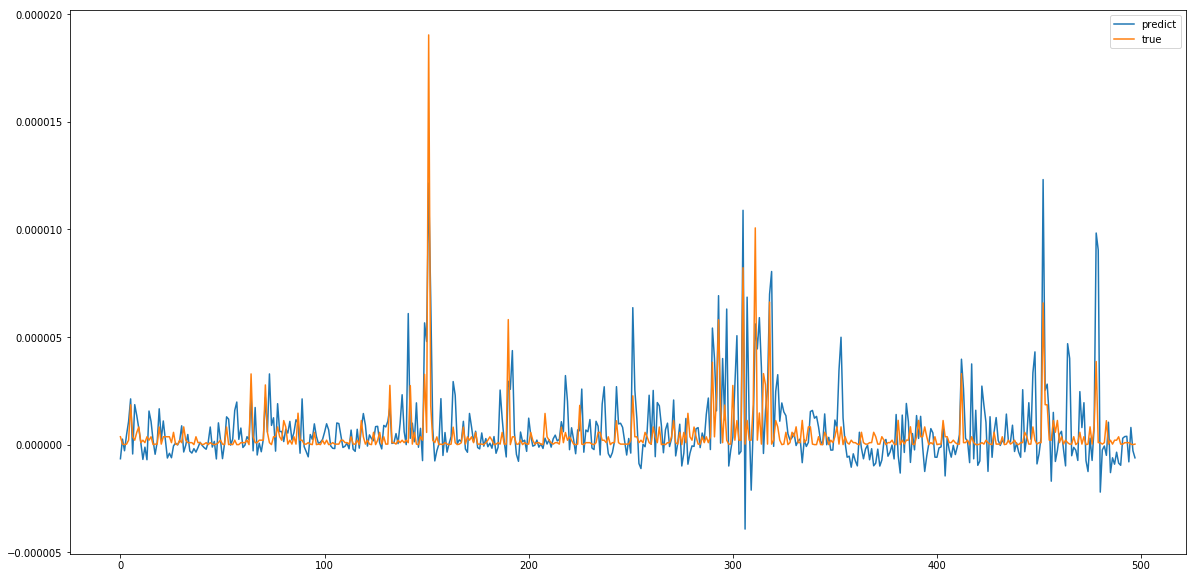

In [175]:
TimeSeriesSplit()

tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)
print(tscv)
for train_index, test_index in tscv.split(np.array(df_new.iloc[:, 1:])):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[train_index], np.array(df_new.iloc[:, 1:])[test_index]
    y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[train_index], np.array(df_new.iloc[:, 0])[test_index]

    model_ols_new = sm.OLS(y_train_new, X_train_new)
    results_ols_new = model_ols_new.fit()
    print(results_ols_new.summary())
    
    print('The length of Y_TEST: ', len(y_test_new))
    
    plt.figure()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(results_ols_new.predict(X_test_new))
    plt.plot(y_test_new)
    plt.legend(['predict', 'true'])
    plt.show()
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     13.74
Date:                Mon, 18 May 2020   Prob (F-statistic):           2.75e-16
Time:                        23:55:00   Log-Likelihood:                 5314.0
No. Observations:                 500   AIC:                        -1.061e+04
Df Residuals:                     493   BIC:                        -1.058e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0018      0.056     -0.033      0.9

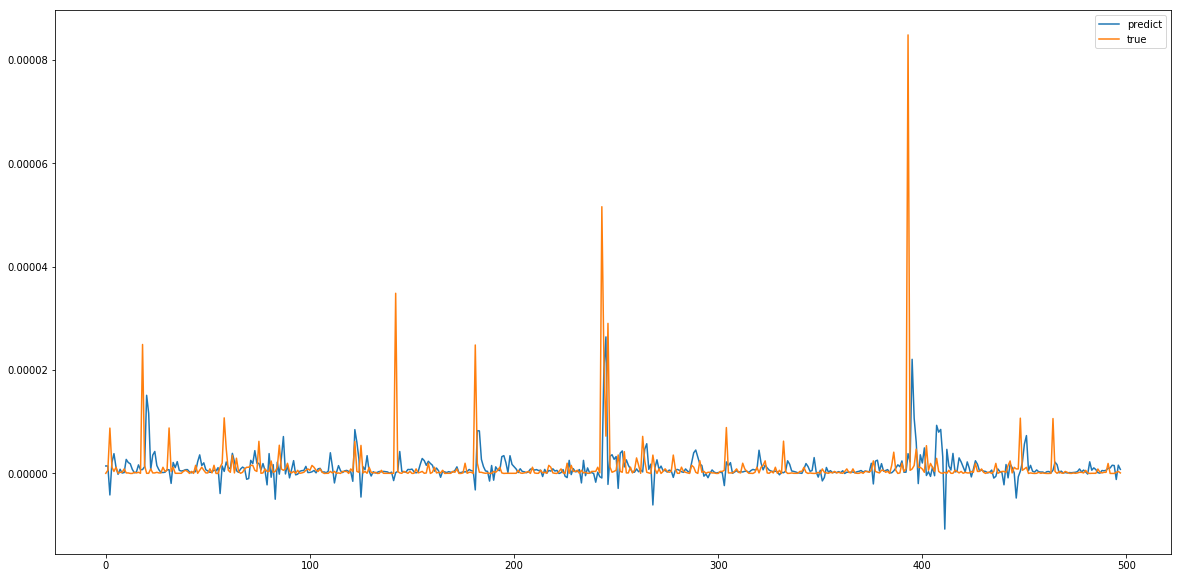

In [181]:
df_new = df_main.copy()
df_new = df_new[[a, b, c, d]][0:2000]

for j in [a, b, c]:
    df_new[j + '_lag1'] = df_new[j].shift(1)
    df_new[j + '_lag2'] = df_new[j].shift(2)

df_new = df_new[[a, a + '_lag1', a + '_lag2',
                 b + '_lag1', b + '_lag2',
                 c + '_lag1', c + '_lag2',
                 d]]
df_new = df_new.dropna().reset_index(drop=True)

X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[:500], np.array(df_new.iloc[:, 1:])[500:998]
y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[:500], np.array(df_new.iloc[:, 0])[500:998]
model_ols_new = sm.OLS(y_train_new, X_train_new)
results_ols_new = model_ols_new.fit()
print(results_ols_new.summary())

    
plt.figure()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(results_ols_new.predict(X_test_new))
plt.plot(y_test_new)
plt.legend(['predict', 'true'])
plt.show()

## Для accuracy

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     390.6
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        22:25:44   Log-Likelihood:                 2261.5
No. Observations:                1900   AIC:                            -4509.
Df Residuals:                    1893   BIC:                            -4470.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7162      0.023     30.944      0.0

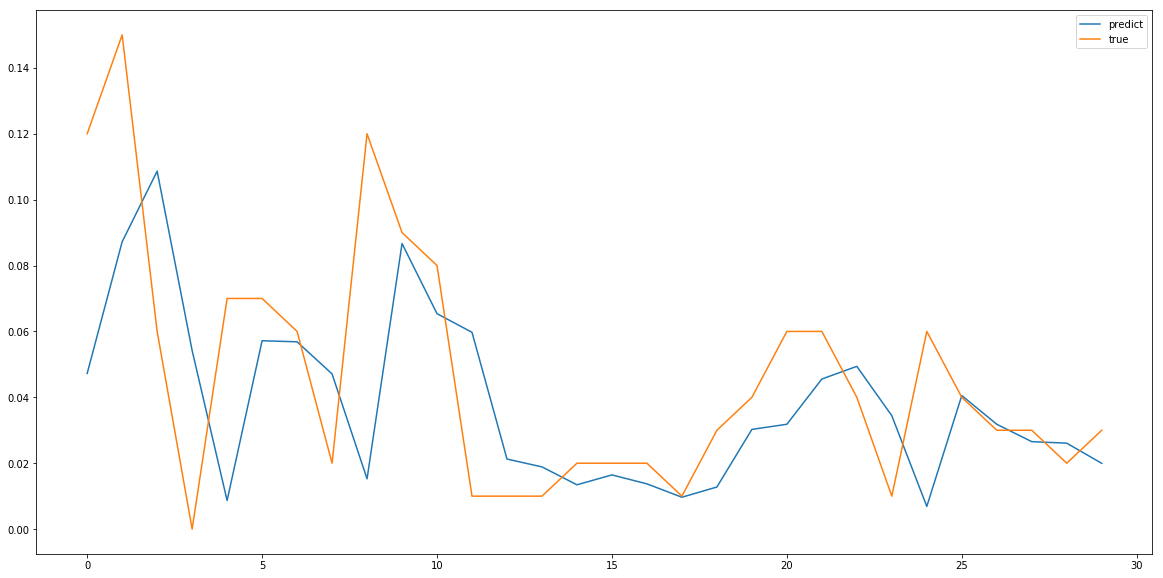

In [133]:
df_new = df_main.copy()
df_new = df_new[[a, b, c, d]][0:2000]

for j in [a, b, c]:
    df_new[j + '_lag1'] = df_new[j].shift(1)
    df_new[j + '_lag2'] = df_new[j].shift(2)

df_new = df_new[[a, a + '_lag1', a + '_lag2',
                 b + '_lag1', b + '_lag2',
                 c + '_lag1', c + '_lag2', 
                 d]]
df_new = df_new.dropna().reset_index(drop=True)

X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[:1900], np.array(df_new.iloc[:, 1:])[1901:1931]
y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[:1900], np.array(df_new.iloc[:, 0])[1901:1931]
model_ols_new = sm.OLS(y_train_new, X_train_new)
results_ols_new = model_ols_new.fit()
print(results_ols_new.summary())

    
plt.figure()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(results_ols_new.predict(X_test_new))
plt.plot(y_test_new)
plt.legend(['predict', 'true'])
plt.show()


In [111]:
y_test_new

array([0.12, 0.15, 0.06, 0.  , 0.07, 0.07, 0.06, 0.02, 0.12, 0.09, 0.08,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.01, 0.03, 0.04, 0.06, 0.06,
       0.04, 0.01, 0.06, 0.04, 0.03, 0.03, 0.02, 0.03])

In [134]:
results_ols = results_ols_new.predict(X_test_new)
df_test_ols = pd.DataFrame(y_test_new, columns = ['y'])
df_forecast_ols = pd.DataFrame(results_ols, columns = ['y*'])
df_result_ols = pd.concat((df_test_ols, df_forecast_ols), axis=1)
sign_real = np.sign(df_result_ols['y'])
sign_pred = np.sign(df_result_ols['y*'])
df_sign = pd.concat((sign_real, sign_pred), axis=1)
errors_sign = sign_real - sign_pred
errors_sign

0     0.0
1     0.0
2     0.0
3    -1.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
dtype: float64

# Внутридневная выборка

In [177]:
# Диапазон для обучения внутри дня (нижняя и верхняя границы)
lst_fronts = [(0, 162), 
              (162, 323),
              (323, 484),
              (484, 645),
              (645, 807),
              (807, 967),
              (967, 1070),
              (1070, 1230),
              (1230, 1391),
              (1391, 1551),
              (1551, 1711),
              (1711, 1872),
              (1872, 2034),
              (2034, 2195),
              (2195, 2356)]

In [178]:
def summary_by_day_for_accuracy(l, h, df_main, a=a, b=b, c=c):
    df_new = df_main.copy()
    df_new = df_new[[a, b, c]][l:h]

    for j in [b]:
        df_new[j + '_lag1'] = df_new[j].shift(1)
        df_new[j + '_lag2'] = df_new[j].shift(2)
        df_new[j + '_lag3'] = df_new[j].shift(3)
        df_new[j + '_lag4'] = df_new[j].shift(4)
        df_new[j + '_lag5'] = df_new[j].shift(5)
        df_new[j + '_lag6'] = df_new[j].shift(6)

    df_new = df_new[[a,
                 b + '_lag1', b + '_lag2', b + '_lag3', b + '_lag4', b + '_lag5', b + '_lag6',
                 c]]
    
    df_new = df_new.dropna().reset_index(drop=True)
    df_new.head()

    tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)
    for train_index, test_index in tscv.split(np.array(df_new.iloc[:, 1:])):
        X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[train_index], np.array(df_new.iloc[:, 1:])[test_index]
        y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[train_index], np.array(df_new.iloc[:, 0])[test_index]

        model_ols_new = sm.OLS(y_train_new, X_train_new)
        results_ols_new = model_ols_new.fit()

    results_ols = results_ols_new.predict(X_test_new)
    results_ols_shift = results_ols[1:]
    errors_ols_shift = abs(y_test_new[:-1] - results_ols_shift)    

    df_errors_ols_shift = pd.DataFrame(errors_ols_shift, columns = ['errors'])
    df_test_ols_shift = pd.DataFrame(y_test_new[:-1], columns = ['y'])
    df_forecast_ols_shift = pd.DataFrame(results_ols_shift, columns = ['y*'])
    df_result_ols_shift = pd.concat((df_errors_ols_shift, df_test_ols_shift, df_forecast_ols_shift), axis=1)    


    
    return results_ols_new.summary()

In [179]:
def summary_all_days(lst_frontiers, df_main, a=a, b=b, c=c):
    summary_all = []
    for frontiers in lst_frontiers:
        l, h = frontiers
        summary_ols = summary_by_day_for_accuracy(l, h, df_main, a=a, b=b, c=c)
        summary_all.append( summary_ols)
    return summary_all

In [180]:
summary_all_days(lst_fronts, df_main)

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.384
 Model:                            OLS   Adj. R-squared:                  0.345
 Method:                 Least Squares   F-statistic:                     9.785
 Date:                Mon, 18 May 2020   Prob (F-statistic):           1.96e-09
 Time:                        22:56:37   Log-Likelihood:                 1347.0
 No. Observations:                 117   AIC:                            -2680.
 Df Residuals:                     110   BIC:                            -2661.
 Df Model:                           7                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

### Accuracy

In [139]:
def accuracy_by_day(l, h, df_main, a=a, b=b, c=c):
    df_new = df_main.copy()
    df_new = df_new[[a, b, c, d]][l:h]

    for j in [a, b, c]:
        df_new[j + '_lag1'] = df_new[j].shift(1)
        df_new[j + '_lag2'] = df_new[j].shift(2)
        df_new[j + '_lag3'] = df_new[j].shift(3)
        df_new[j + '_lag4'] = df_new[j].shift(4)
        df_new[j + '_lag5'] = df_new[j].shift(5)
        df_new[j + '_lag6'] = df_new[j].shift(6)

    df_new = df_new[[a, a + '_lag1', a + '_lag2', a + '_lag3', a + '_lag4', a + '_lag5', a + '_lag6',
                     b + '_lag1', b + '_lag2', b + '_lag3', b + '_lag4', b + '_lag5', b + '_lag6',
                     c + '_lag1', c + '_lag2', c + '_lag3', c + '_lag4', c + '_lag5', c + '_lag6',
                     d]]
    
    df_new = df_new.dropna().reset_index(drop=True)
    df_new.head()

    tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)
    for train_index, test_index in tscv.split(np.array(df_new.iloc[:, 1:])):
        X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[train_index], np.array(df_new.iloc[:, 1:])[test_index]
        y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[train_index], np.array(df_new.iloc[:, 0])[test_index]

        model_ols_new = sm.OLS(y_train_new, X_train_new)
        results_ols_new = model_ols_new.fit()

    results_ols = results_ols_new.predict(X_test_new)
    results_ols_shift = results_ols[1:]
    errors_ols_shift = abs(y_test_new[:-1] - results_ols_shift)    

    df_errors_ols_shift = pd.DataFrame(errors_ols_shift, columns = ['errors'])
    df_test_ols_shift = pd.DataFrame(y_test_new[:-1], columns = ['y'])
    df_forecast_ols_shift = pd.DataFrame(results_ols_shift, columns = ['y*'])
    df_result_ols_shift = pd.concat((df_errors_ols_shift, df_test_ols_shift, df_forecast_ols_shift), axis=1)    

    results_ols = results_ols_new.predict(X_test_new)
    df_test_ols = pd.DataFrame(y_test_new, columns = ['y'])
    df_forecast_ols = pd.DataFrame(results_ols, columns = ['y*'])
    df_result_ols = pd.concat((df_test_ols, df_forecast_ols), axis=1)
    sign_real = np.sign(df_result_ols['y'])
    sign_pred = np.sign(df_result_ols['y*'])
    df_sign = pd.concat((sign_real, sign_pred), axis=1)
    errors_sign = sign_real - sign_pred
    signs_all = np.array(errors_sign)
    
    return signs_all.size

In [140]:
def summary_all_days(lst_frontiers, df_main, a=a, b=b, c=c):
    summary_all = []
    for frontiers in lst_frontiers:
        l, h = frontiers
        summary_ols = accuracy_by_day(l, h, df_main, a=a, b=b, c=c)
        summary_all.append( summary_ols)
    return summary_all

In [141]:
signs = summary_all_days(lst_fronts, df_main)

In [142]:
signs

[39, 38, 38, 38, 39, 38, 24, 38, 38, 38, 38, 38, 39, 38, 38]

In [143]:
def accuracy_by_day(l, h, df_main, a=a, b=b, c=c):
    df_new = df_main.copy()
    df_new = df_new[[a, b, c, d]][l:h]

    for j in [a, b, c]:
        df_new[j + '_lag1'] = df_new[j].shift(1)
        df_new[j + '_lag2'] = df_new[j].shift(2)
        df_new[j + '_lag3'] = df_new[j].shift(3)
        df_new[j + '_lag4'] = df_new[j].shift(4)
        df_new[j + '_lag5'] = df_new[j].shift(5)
        df_new[j + '_lag6'] = df_new[j].shift(6)

    df_new = df_new[[a, a + '_lag1', a + '_lag2', a + '_lag3', a + '_lag4', a + '_lag5', a + '_lag6',
                     b + '_lag1', b + '_lag2', b + '_lag3', b + '_lag4', b + '_lag5', b + '_lag6',
                     c + '_lag1', c + '_lag2', c + '_lag3', c + '_lag4', c + '_lag5', c + '_lag6',
                     d]]
    
    df_new = df_new.dropna().reset_index(drop=True)
    df_new.head()

    tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)
    for train_index, test_index in tscv.split(np.array(df_new.iloc[:, 1:])):
        X_train_new, X_test_new = np.array(df_new.iloc[:, 1:])[train_index], np.array(df_new.iloc[:, 1:])[test_index]
        y_train_new, y_test_new = np.array(df_new.iloc[:, 0])[train_index], np.array(df_new.iloc[:, 0])[test_index]

        model_ols_new = sm.OLS(y_train_new, X_train_new)
        results_ols_new = model_ols_new.fit()

    results_ols = results_ols_new.predict(X_test_new)
    results_ols_shift = results_ols[1:]
    errors_ols_shift = abs(y_test_new[:-1] - results_ols_shift)    

    df_errors_ols_shift = pd.DataFrame(errors_ols_shift, columns = ['errors'])
    df_test_ols_shift = pd.DataFrame(y_test_new[:-1], columns = ['y'])
    df_forecast_ols_shift = pd.DataFrame(results_ols_shift, columns = ['y*'])
    df_result_ols_shift = pd.concat((df_errors_ols_shift, df_test_ols_shift, df_forecast_ols_shift), axis=1)    

    results_ols = results_ols_new.predict(X_test_new)
    df_test_ols = pd.DataFrame(y_test_new, columns = ['y'])
    df_forecast_ols = pd.DataFrame(results_ols, columns = ['y*'])
    df_result_ols = pd.concat((df_test_ols, df_forecast_ols), axis=1)
    sign_real = np.sign(df_result_ols['y'])
    sign_pred = np.sign(df_result_ols['y*'])
    df_sign = pd.concat((sign_real, sign_pred), axis=1)
    errors_sign = sign_real - sign_pred
    signs_all = np.array(errors_sign)
    
    return np.count_nonzero(signs_all)

In [144]:
def summary_all_days(lst_frontiers, df_main, a=a, b=b, c=c):
    summary_all = []
    for frontiers in lst_frontiers:
        l, h = frontiers
        summary_ols = accuracy_by_day(l, h, df_main, a=a, b=b, c=c)
        summary_all.append( summary_ols)
    return summary_all

In [145]:
signs = summary_all_days(lst_fronts, df_main)
signs

[6, 3, 7, 5, 7, 4, 3, 10, 2, 5, 3, 5, 4, 9, 8]